# Practice: Dealing with texts using CNN
_Reference: Based on YSDA [materials](https://github.com/yandexdataschool/nlp_course/blob/master/week02_classification/seminar.ipynb). Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

## About the challenge
For starters, let's download and unpack the data.

You can also get it from [Yandex.Disk](https://yadi.sk/d/vVEOWPFY3NruT7) or [the competition page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
# !curl -L "https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1" -o Train_rev1.csv.tar.gz
# !tar xzf Train_rev1.csv.tar.gz

In [3]:
import pandas as pd


data = pd.read_csv("Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [5]:
for column in data.columns:
    print(column)

Id
Title
FullDescription
LocationRaw
LocationNormalized
ContractType
ContractTime
Company
Category
SalaryRaw
SalaryNormalized
SourceName
Log1pSalary


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

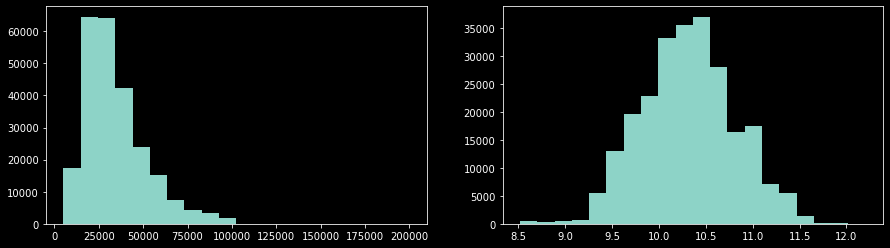

In [7]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("dark_background")

data["Log1pSalary"] = np.log1p(data["SalaryNormalized"]).astype("float32")

plt.figure(figsize=[15, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(data["Log1pSalary"], bins=20)

plt.show()

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [8]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna("NaN")
data[text_columns] = data[text_columns].fillna("NaN")

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
4367,61515599,Product Support Engineer (Visual Basic),We are recruiting for a Product Support Engine...,Dartford,Dartford,NaN,permanent,NaN,Engineering Jobs,30000-42000,36000,hays.co.uk,10.491302
73246,68994048,Senior Risk Consultant SAS Leeds c****,Job Title: Senior Risk Consultant Location: Le...,Leeds,Leeds,NaN,permanent,Aspire Data Recruitment,Accounting & Finance Jobs,"0 - 55000 per annum, Benefits: Car, Bonus & Be...",27500,jobsinrisk.com,10.221977
67618,68720445,Healthcare Assistant HCA Required in Northam...,"We have terrific opportunities for confident, ...",Northampton,Northampton,full_time,NaN,Thornbury Nursing,Healthcare & Nursing Jobs,"12,000 - 18,000/Year",15000,staffnurse.com,9.615872


## Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [9]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [10]:
from nltk.tokenize import WordPunctTokenizer


tokenizer = WordPunctTokenizer()

# YOUR CODE HERE
# Lowercase and tokenize titles and descriptions (text_columns).
# Store items as space-separated strings of tokens.

def normalise(text):
    return " ".join(tokenizer.tokenize(str(text).lower()))

data[text_columns] = data[text_columns].applymap(normalise)

In [ ]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == "mathematical modeller / simulation analyst / opera"
assert data["Title"][54321] == "international digital account manager ( german )"

Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
from collections import Counter


# YOUR CODE HERE
# Count how many times does each token occur in both "Title" and "FullDescription".
# Build a dictionary { token -> count }.
# Hint: you may or may not want to use collections.Counter
# token_counts = ...
token_counts = Counter()
for text in data[text_columns].values.flatten():
    token_counts.update(text.split(" "))

In [ ]:
print("Total unique tokens :", len(token_counts))
print("\n".join(map(str, token_counts.most_common(n=5))))
print("...")
print("\n".join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print("Correct!")

Let's see how many words are there for each count.

In [ ]:
plt.hist(list(token_counts.values()), range=[0, 10 ** 4], bins=50, log=True)
plt.xlabel("Word counts")
plt.show()

Now we will filter tokens a list of all tokens that occur at least 10 times.

In [ ]:
min_count = 10

# YOUR CODE HERE
# We shall only consider tokens that had at least min_count occurences.
# Create a list of such tokens.
# tokens = ...

In [ ]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert "me" in tokens
assert UNK in tokens
print("Correct!")

Build an inverse token index: a dictionary from token to it's index in `tokens`.

In [ ]:
# YOUR CODE HERE
# token_to_idx = ...

In [ ]:
assert isinstance(token_to_idx, dict)
assert len(token_to_idx) == len(tokens)
for tok in tokens:
    assert tokens[token_to_idx[tok]] == tok

print("Correct!")

And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [ ]:
UNK_IDX = token_to_idx[UNK]
PAD_IDX = token_to_idx[PAD]


def as_matrix(sequences, max_len=None):
    """Convert a list of tokens into a matrix with padding"""
    if isinstance(sequences[0], str):
        sequences = [seq.split(" ") for seq in sequences]

    sequences_max_len = max(len(seq) for seq in sequences)
    if max_len is None:
        max_len = sequences_max_len
    else:
        max_len = min(sequences_max_len, max_len)

    matrix = np.full((len(sequences), max_len), PAD_IDX)
    for i, seq in enumerate(sequences):
        for j, token in enumerate(seq):
            if j >= max_len:
                break

            matrix[i, j] = token_to_idx.get(token, UNK_IDX)

    return matrix

In [ ]:
print("Lines:")
print("\n".join(data["Title"][::100000].values), end="\n\n")
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [ ]:
from sklearn.feature_extraction import DictVectorizer


# We only consider top-1k most frequent companies to minimize memory usage
company_counts = Counter(data["Company"])
top_companies = set(name for name, count in company_counts.most_common(1000))
data["Company"] = data["Company"].apply(
    lambda company: company if company in top_companies else "Other"
)

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1));

## The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [ ]:
from sklearn.model_selection import train_test_split


data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

In [ ]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a neural-network-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IDX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch["Categorical"] = categorical_vectorizer.transform(
        data[categorical_columns].apply(dict, axis=1)
    )

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1.0 - word_dropout)

    if target_column in data.columns:
        batch[target_column] = data[target_column].values

    return batch


def apply_word_dropout(matrix, keep_prob, replace_with=UNK_IDX):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prob, 1 - keep_prob])
    dropout_mask &= matrix != PAD_IDX
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [ ]:
example_batch = make_batch(data_train[:3], max_len=10)
print("Example batch:")
print(example_batch)
print("FullDescription shape:", example_batch["FullDescription"].shape)

In [ ]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """iterates minibatches of data in random order"""
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target

        if not cycle:
            break

To generate minibatches we will use simple pyton generator.

In [ ]:
iterator = iterate_minibatches(data_train, 3)
batch, target = next(iterator)

## Architecture

Our main model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into PyTorch __Sequential__ interface. To build such a network, one will have to use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

But to start with let's build the simple model using only the part of the data. Let's create the baseline solution using only the description part (so it should definetely fit into the Sequential model).

In [ ]:
import torch.nn as nn


# Initially, our FullDescription has a shape [batch_size, seq_len].
# After an Embedding layer shape will be [batch_size, seq_len, embedding_size].
# However, Conv1d layer expects batches of shape [batch_size, embedding_size, seq_len].
# We will use this layer to fix this misunderstanding.
class Reorder(nn.Module):
    def forward(self, input):
        return input.permute((0, 2, 1))

In [ ]:
simple_model = nn.Sequential(
    # YOUR CODE HERE
)

__Remember!__ We are working with regression problem and predicting only one number.

In [ ]:
import torch


# Check your model. `torch.long` tensors are required for nn.Embedding layers.
simple_model(torch.tensor(batch["FullDescription"], dtype=torch.long))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simple_model.to(device);

And now simple training pipeline:

In [ ]:
from IPython.display import clear_output


epochs = 1
model = simple_model
opt = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

history = []
for epoch in range(epochs):
    for batch, target in iterate_minibatches(data_train):
        # Preprocessing the batch data and target
        batch = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        target = torch.tensor(target, device=device)

        predictions = model(batch)
        predictions = predictions.flatten()

        # YOUR CODE HERE
        # Compute loss.

        # YOUR CODE HERE
        # Train with backprop.

        history.append(loss.item())
        if len(history) % 10 == 0:
            clear_output(wait=True)
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

To evaluate the model we can switch it to `eval` state. Let's check the model quality.

In [ ]:
@torch.no_grad()
def evaluate_model(model, data, batch_size=256, name=None, **kwargs):
    squared_error = abs_error = num_samples = 0.0
    data_iterator = iterate_minibatches(data, batch_size, shuffle=False, **kwargs)
    for batch, target in data_iterator:
        batch = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        pred = model(batch)[:, 0].cpu().numpy()

        squared_error += np.sum(np.square(pred - target))
        abs_error += np.sum(np.abs(pred - target))
        num_samples += len(target)

    if name is not None:
        print(f"{name}:")

    print(f"MSE: {squared_error / num_samples:.5f}")
    print(f"MAE: {abs_error / num_samples:.5f}")


evaluate_model(simple_model, data_train, name="Train")
evaluate_model(simple_model, data_val, name="Val")

### Bonus area 1: three-headed network.

Now you can try to implement the network we've discussed above. Use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

In [ ]:
class ThreeInputsNet(nn.Module):
    def __init__(
        self,
        n_tokens=len(tokens),
        n_cat_features=len(categorical_vectorizer.vocabulary_),
        hid_size=64,
    ):
        super().__init__()

        self.title_emb = nn.Embedding(n_tokens, hid_size)
        # YOUR CODE HERE
        # Define modules to process the title.

        self.desc_emb = nn.Embedding(n_tokens, hid_size)
        # YOUR CODE HERE
        # Define modules to process the description.

        # YOUR CODE HERE
        # Define modules to process the categorical features.
        # self.category_out = ...

        # YOUR CODE HERE
        # Define fully-connected part which will take outputs of
        # three heads and return the result.
        # self.out = ...

    def forward(self, whole_input):
        input1, input2, input3 = whole_input
        title_beg = self.title_emb(input1).permute((0, 2, 1))
        # YOUR CODE HERE
        # Process the title.
        # title = ...

        full_beg = self.full_emb(input2).permute((0, 2, 1))
        # YOUR CODE HERE
        # Process the description.
        # desc = ...

        # YOUR CODE HERE
        # Process the categorical features.
        # category = ...

        concatenated = torch.cat(
            [
                title.view(title.size(0), -1),
                desc.view(desc.size(0), -1),
                category.view(category.size(0), -1),
            ],
            dim=1,
        )

        # YOUR CODE HERE
        # Process the concatenated features to generate network output.
        # out = ...

        return out

### Bonus area 2: comparing RNN to CNN
Try implementing simple RNN (or LSTM) and applying it to this task. Compare the quality/performance of these networks. 
*Hint: try to build networks with ~same number of paremeters.*

In [ ]:
# YOUR CODE HERE

### Bonus area 3: fixing the data leaks
Fix the data leak we ignored in the beginning of the __Deep Learning part__. Compare results with and without data leaks using same architectures and training time.


In [ ]:
# YOUR CODE HERE

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)